In [109]:
import numpy as np
import matplotlib.pyplot as plt
import os
import random
import torch
from torch import nn, optim

from torch.nn import functional as F
from torchvision import transforms as T
from torch.utils.data import DataLoader, Dataset, random_split
import torchvision.transforms.functional as TF

import PIL
from PIL import Image

In [110]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


**Preprocessing**

Change format for images: JPG -> PNG

In [105]:
from PIL import Image
import os
ROOT_FOLDER_IMAGES='trainsetRNN/new_images'
for folder_typeOfDataAug in set(os.listdir(ROOT_FOLDER_IMAGES))-{'desktop.ini'}:
    for folder_videoCaptured in set(os.listdir(os.path.join(ROOT_FOLDER_IMAGES,folder_typeOfDataAug)))-{'desktop.ini'}:
        folder_images_path = os.path.join(ROOT_FOLDER_IMAGES,folder_typeOfDataAug,folder_videoCaptured)
            
        # Obtener la lista de archivos en la carpeta
        archivos = os.listdir(folder_images_path)

        # Procesar cada archivo en la carpeta
        for archivo in archivos:
            # Comprobar si el archivo es una imagen JPG
            if archivo.endswith(".jpg") or archivo.endswith(".jpeg"):
                # Ruta completa de la imagen JPG
                ruta_imagen_jpg = os.path.join(folder_images_path, archivo)

                # Abrir la imagen JPG
                imagen_jpg = Image.open(ruta_imagen_jpg)

                # Cambiar el formato de la imagen a PNG
                nombre_archivo, _ = os.path.splitext(archivo)  # Obtener el nombre del archivo sin la extensión
                ruta_imagen_png = os.path.join(folder_images_path, nombre_archivo + ".png")  # Ruta completa de la imagen PNG

                # Guardar la imagen en formato PNG
                imagen_jpg.save(ruta_imagen_png, "PNG")

                # Opcionalmente, eliminar la imagen JPG original
                os.remove(ruta_imagen_jpg)

Process masks: Add masks in case there are less than original

In [ ]:
import re
import time
import os
from IPython.display import display
ROOT_FOLDER_IMAGES='trainsetRNN/new_image'
ROOT_FOLDER_MASKS='trainsetRNN/new_masks'
for folder_typeOfDataAug in os.listdir(ROOT_FOLDER_MASKS):
    for folder_videoCaptured in os.listdir(os.path.join(ROOT_FOLDER_MASKS,folder_typeOfDataAug)):
        folder_masks_path = os.path.join(ROOT_FOLDER_MASKS,folder_typeOfDataAug,folder_videoCaptured)
        folder_images_path = os.path.join(ROOT_FOLDER_IMAGES,folder_typeOfDataAug,folder_videoCaptured)
        list_masks = os.listdir(folder_masks_path)
        
        listaMasksFaltantesPaths=[os.path.join(folder_masks_path, image) for image in os.listdir(folder_images_path) if image not in list_masks]
        print(listaMasksFaltantesPaths)
        for new_mask_path in listaMasksFaltantesPaths:
            mask = Image.new("1", (720, 1080), color=0)
            #display(mask)
            mask.save(new_mask_path)


Process masks: Cambiar de rojo a blanco la mascara

In [108]:
import re
import time
from IPython.display import display
ROOT_FOLDER_MASKS='trainsetRNN/new_images/new_masks'
for folder_typeOfDataAug in set(os.listdir(ROOT_FOLDER_MASKS))-{'desktop.ini'}:
    for folder_videoCaptured in set(os.listdir(os.path.join(ROOT_FOLDER_MASKS,folder_typeOfDataAug)))-{'desktop.ini'}:
        folder_images_path = os.path.join(ROOT_FOLDER_MASKS,folder_typeOfDataAug,folder_videoCaptured)
        ordered = set(os.listdir(os.path.join(folder_images_path)))-{'desktop.ini'}
        ordered = [name[6:] for name in ordered]
        print(ordered)
        ordered.sort(key=lambda f: int(re.sub('\D', '', f)))
        print(ordered)
        image_list = [os.path.join(folder_images_path, "frame_"+image) for image in ordered]
        print(image_list)
        for image_path in image_list:
            image = Image.open(image_path)
            thresh = 1
            fn = lambda x : 255 if x > thresh else 0
            imagen_bn = image.convert('L').point(fn, mode='1')
            print(imagen_bn.size)
            #print(imagen_bn.mode)
            #display(imagen_bn)
            imagen_bn.save(image_path)


['128.png', '13.png', '52.png', '239.png', '178.png', '108.png', '136.png', '175.png', '224.png', '70.png', '35.png', '44.png', '152.png', '45.png', '59.png', '86.png', '167.png', '213.png', '215.png', '71.png', '17.png', '135.png', '83.png', '92.png', '156.png', '15.png', '194.png', '173.png', '185.png', '218.png', '51.png', '63.png', '236.png', '115.png', '151.png', '68.png', '18.png', '118.png', '124.png', '0.png', '222.png', '47.png', '26.png', '220.png', '161.png', '93.png', '180.png', '8.png', '160.png', '119.png', '87.png', '33.png', '67.png', '221.png', '234.png', '208.png', '145.png', '100.png', '144.png', '97.png', '120.png', '66.png', '30.png', '129.png', '131.png', '199.png', '205.png', '80.png', '89.png', '9.png', '190.png', '200.png', '42.png', '105.png', '195.png', '216.png', '154.png', '164.png', '62.png', '84.png', '232.png', '10.png', '12.png', '142.png', '110.png', '126.png', '140.png', '147.png', '211.png', '77.png', '96.png', '28.png', '123.png', '56.png', '101.png

**DATASET**

In [113]:
def agruparSecuencias(batch):
    
    # Add channel dim, scale pixels between 0 and 1, send to GPU
    batch = torch.tensor(batch).unsqueeze(1)     
    batch = batch / 255.0                        
    batch = batch.to(device)                     

    # Randomly pick 10 frames as input, 11th frame is target
    rand = np.random.randint(10,20)                     
    return batch[:,:,rand-10:rand], batch[:,:,rand]     

In [114]:
import re
import os
ROOT_FOLDER_IMAGES='trainsetRNN/imageSequences'
ROOT_FOLDER_MASKS='trainsetRNN/truthSequences'

#PROBANDO
'''
for folder_typeOfDataAug in os.listdir(ROOT_FOLDER_IMAGES):
    #print(folder_typeOfDataAug)
    for folder_videoCaptured in os.listdir(os.path.join(ROOT_FOLDER_IMAGES,folder_typeOfDataAug)):
        #print(" ",folder_videoCaptured)
        for folder_sequence in os.listdir(os.path.join(ROOT_FOLDER_IMAGES,folder_typeOfDataAug,folder_videoCaptured)):
            #print("  ", folder_sequence)
            #print(sum(1 for entry in os.scandir(os.path.join(ROOT_FOLDER_IMAGES,folder_typeOfDataAug,folder_videoCaptured, folder_sequence)) if entry.is_file()))
            print(type(os.listdir(os.path.join(ROOT_FOLDER_IMAGES,folder_typeOfDataAug,folder_videoCaptured, folder_sequence))))
            for image in os.listdir(os.path.join(ROOT_FOLDER_IMAGES,folder_typeOfDataAug,folder_videoCaptured, folder_sequence)):
                #print("   ", image)
                pass
'''
list=[]
Sequences_dict={"Images":[], "Mask_output":[]}
for folder_typeOfDataAug in set(os.listdir(ROOT_FOLDER_IMAGES))-{'desktop.ini'}:
    for folder_videoCaptured in set(os.listdir(os.path.join(ROOT_FOLDER_IMAGES,folder_typeOfDataAug)))-{'desktop.ini'}:
        for folder_sequence in set(os.listdir(os.path.join(ROOT_FOLDER_IMAGES,folder_typeOfDataAug,folder_videoCaptured)))-{'desktop.ini'}:
            folder_images_path = os.path.join(ROOT_FOLDER_IMAGES,folder_typeOfDataAug,folder_videoCaptured, folder_sequence)
            ordered = os.listdir(os.path.join(folder_images_path))
            image_list = [os.path.join(folder_images_path, image) for image in ordered if image!="desktop.ini"]

            folder_masks_path = os.path.join(ROOT_FOLDER_MASKS,folder_typeOfDataAug,folder_videoCaptured)
            mask_filename = folder_sequence+".png"
            mask = os.path.join(folder_masks_path, mask_filename)

            Sequences_dict["Images"]=image_list[-5:]
            Sequences_dict["Mask_output"]=mask
            list.append(Sequences_dict)
            print(Sequences_dict)

{'Images': ['trainsetRNN/imageSequences\\Blurred\\videoPrueba5\\25\\0.png', 'trainsetRNN/imageSequences\\Blurred\\videoPrueba5\\25\\1.png', 'trainsetRNN/imageSequences\\Blurred\\videoPrueba5\\25\\2.png', 'trainsetRNN/imageSequences\\Blurred\\videoPrueba5\\25\\3.png', 'trainsetRNN/imageSequences\\Blurred\\videoPrueba5\\25\\4.png'], 'Mask_output': 'trainsetRNN/truthSequences\\Blurred\\videoPrueba5\\25.png'}
{'Images': ['trainsetRNN/imageSequences\\Blurred\\videoPrueba5\\106\\0.png', 'trainsetRNN/imageSequences\\Blurred\\videoPrueba5\\106\\1.png', 'trainsetRNN/imageSequences\\Blurred\\videoPrueba5\\106\\2.png', 'trainsetRNN/imageSequences\\Blurred\\videoPrueba5\\106\\3.png', 'trainsetRNN/imageSequences\\Blurred\\videoPrueba5\\106\\4.png'], 'Mask_output': 'trainsetRNN/truthSequences\\Blurred\\videoPrueba5\\106.png'}
{'Images': ['trainsetRNN/imageSequences\\Blurred\\videoPrueba5\\63\\0.png', 'trainsetRNN/imageSequences\\Blurred\\videoPrueba5\\63\\1.png', 'trainsetRNN/imageSequences\\Blurred

In [115]:
class CrackDatasetRNN(Dataset):
    def __init__(self, dataPath, masksPath, img_transforms=None, mask_transforms=None, sequence_size=5):

        self.train_data = dataPath
        self.train_masks = masksPath
        
        self.img_transforms = img_transforms
        self.mask_transforms = mask_transforms
        
        self.listSequences=[]
        self.sequence_size = sequence_size
        
        for folder_typeOfDataAug in set(os.listdir(ROOT_FOLDER_IMAGES))-{'desktop.ini'}:
            for folder_videoCaptured in set(os.listdir(os.path.join(ROOT_FOLDER_IMAGES,folder_typeOfDataAug)))-{'desktop.ini'}:
                for folder_sequence in set(os.listdir(os.path.join(ROOT_FOLDER_IMAGES,folder_typeOfDataAug,folder_videoCaptured)))-{'desktop.ini'}:
                    folder_images_path = os.path.join(ROOT_FOLDER_IMAGES,folder_typeOfDataAug,folder_videoCaptured, folder_sequence)
                    ordered = os.listdir(os.path.join(folder_images_path))
                    image_list = [os.path.join(folder_images_path, image) for image in ordered if image!="desktop.ini"]

                    folder_masks_path = os.path.join(ROOT_FOLDER_MASKS,folder_typeOfDataAug,folder_videoCaptured)
                    mask_filename = folder_sequence+".png"
                    mask = os.path.join(folder_masks_path, mask_filename)

                    Sequences_dict={"Images":[], "Mask_output":[]}
                    Sequences_dict["Images"]=image_list[-sequence_size:]
                    Sequences_dict["Mask_output"]=mask
                    self.listSequences.append(Sequences_dict)
                    #print(Sequences_dict)
                    
    def __len__(self):
        return len(self.listSequences)    
    def __getitem__(self, idx):
        listImagesPaths =self.listSequences[idx]["Images"]
        listImages=[]
        for imagePath in listImagesPaths:
            imageOpened = Image.open(imagePath)    
            trans = T.ToTensor()
            if self.img_transforms is not None:
                img = self.img_transforms(imageOpened)
            else:
                img =trans(imageOpened)
            listImages.append(img)
        #print(listImagesPaths)
        listImagesTorch = torch.stack(listImages)
        
        if self.train_masks is not None:
            mask_path = self.listSequences[idx]["Mask_output"]
            mask = Image.open(mask_path)
            if self.mask_transforms is not None:
                mask = self.mask_transforms(mask)
            else:
                mask = trans(mask)
        else:
            return img
        
        return listImagesTorch, mask    

In [116]:
transform_data = T.Compose([
                T.Resize([224, 224]),
                T.ToTensor(),
                T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

transform_data_target = T.Compose([
                T.Resize([224, 224]),
                #T.Grayscale(1),
                T.ToTensor(),
                T.Lambda(lambda x: torch.where(x > 0.5, torch.tensor([1.0]), torch.tensor([0.0])))
                ])

In [117]:
full_dataset = CrackDatasetRNN(ROOT_FOLDER_IMAGES,
                           ROOT_FOLDER_MASKS,
                           img_transforms=transform_data,
                           mask_transforms=transform_data_target,
                           sequence_size=5)

In [118]:
BATCH_SIZE = 4
TRAIN_SIZE = int(len(full_dataset)*0.8)
VAL_SIZE = len(full_dataset) - TRAIN_SIZE
print(TRAIN_SIZE, VAL_SIZE)
train_dataset, val_dataset = random_split(full_dataset, [TRAIN_SIZE, VAL_SIZE])
print(train_dataset[0][0].shape)
print(train_dataset[0][1].shape)

380 96
torch.Size([5, 3, 224, 224])
torch.Size([1, 224, 224])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


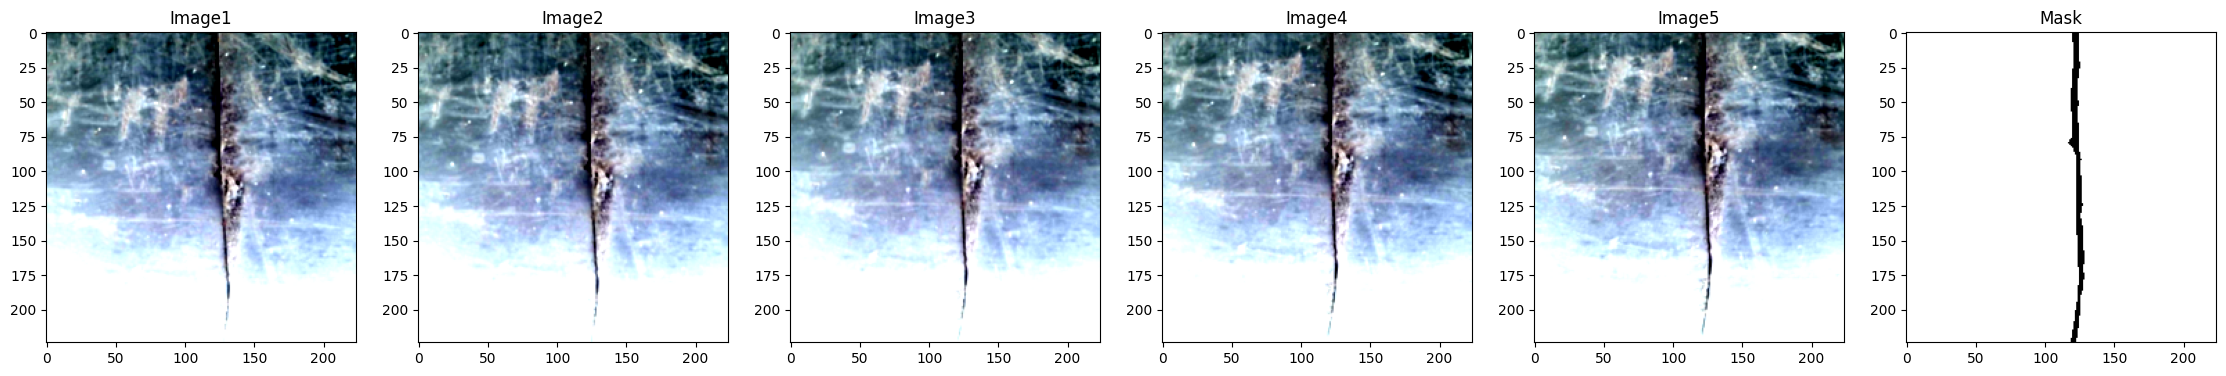

In [119]:
#Check image and mask
id = 2
fig, ax = plt.subplots(1, 6, figsize=(28, 6))
ax[0].imshow(train_dataset[id][0][0].permute(1, 2, 0));ax[0].set_title("Image1")
ax[1].imshow(train_dataset[id][0][1].permute(1, 2, 0));ax[1].set_title("Image2")
ax[2].imshow(train_dataset[id][0][2].permute(1, 2, 0));ax[2].set_title("Image3")
ax[3].imshow(train_dataset[id][0][3].permute(1, 2, 0));ax[3].set_title("Image4")
ax[4].imshow(train_dataset[id][0][4].permute(1, 2, 0));ax[4].set_title("Image5")
ax[5].imshow(train_dataset[id][1][0],'binary');ax[5].set_title("Mask")
plt.show()

**DATALOADER**

In [120]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [121]:
imgs, masks = next(iter(train_loader))
print(imgs.shape, masks.shape)

torch.Size([4, 5, 3, 224, 224]) torch.Size([4, 1, 224, 224])


**Model**

In [122]:
from modelUnetConvLSTM import *
modelo = UNET_ConvLSTM(3, 16, 2)
modelo.to(device)
print(modelo)

UNET_ConvLSTM(
  (first_conv): Double_Conv(
    (double_conv): Sequential(
      (0): Conv_3_k(
        (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv_3_k(
        (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
    )
  )
  (down_conv1): Down_Conv(
    (encoder): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): Double_Conv(
        (double_conv): Sequential(
          (0): Conv_3_k(
            (conv1): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          )
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
          (3): Conv_3_k(
         

**Training**

In [123]:
def accuracy(model, loader):
    correct = 0
    intersection = 0
    denom = 0
    union = 0
    total = 0
    cost = 0.
    model = model.to(device=device)
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype = torch.float32)
            y = y.to(device=device, dtype = torch.long).squeeze(1)
            scores = model(x)
            cost += (F.cross_entropy(scores, y)).item()
            # standard accuracy not optimal
            preds = torch.argmax(scores, dim=1)
            correct += (preds == y).sum()
            total += torch.numel(preds)
            #dice coefficient
            intersection += (preds*y).sum()
            denom += (preds + y).sum()
            dice = 2*intersection/(denom + 1e-8)
            #intersection over union
            union += (preds + y - preds*y).sum()
            iou = (intersection)/(union + 1e-8)
            
        return cost/len(loader), float(correct)/total, dice, iou    

In [124]:
from torch.utils.tensorboard import SummaryWriter

# Writer will output to ./runs/ directory by default
writer = SummaryWriter()
val_losses = []
train_losses = []

train_accs = []
val_accs = []

train_iou = []
val_iou = []

In [125]:
def train(dataloader, model, loss_function, optimizer, epoch, store_every=9):
    train_correct_num, train_total, train_cost_acum = 0, 0, 0.0
    intersection, union = 0, 0
    model.train()
    for batch, (x,y) in enumerate(dataloader):
        x = x.to(device=device, dtype=torch.float32)
        x = x.transpose(0, 1)
        y = y.to(device=device, dtype=torch.long).squeeze(1)
        print(x.shape)
        scores = model(x)
        print(scores.shape)
        cost = loss_function(input=scores, target=y)
        #cost.requires_grad = True


        #Backpropagation
        optimizer.zero_grad()
        cost.backward()
        optimizer.step()

        train_predictions = torch.argmax(scores, dim=1)
        train_correct_num += (train_predictions == y).sum()
        train_total += torch.numel(train_predictions)#total numero de elementos de train_predictions, if size=[a,b,c ] returns a*b*c
        train_cost_acum += cost
        
        #print(train_predictions.shape, y.shape)

        #IOU
        intersection += (train_predictions*y).sum()
        union += (train_predictions + y - train_predictions*y).sum()
 
        if batch % store_every == 1:#1 cuz division by zero
            train_acc = float(train_correct_num)/train_total#el train total ya considera el batch
            train_cost_every = float(train_cost_acum)/batch#Se divide entre el batch, xq por cada batch se aumenta el loss
            iou_every = ((intersection)/(union + 1e-8)).item()
            writer.add_scalar('training loss',
                            train_cost_every,
                            epoch * len(dataloader) + batch)#len(dataloader) returns total number of batchs in an epoch
            writer.add_scalar('training accuracy',
                            train_acc,
                            epoch * len(dataloader) + batch)
            writer.add_scalar('training IOU',
                            iou_every,
                            epoch * len(dataloader) + batch)
            
            print("loss: ", train_cost_every, "Accuracy: ", train_acc, "IOU: ", iou_every)
            train_losses.append(train_cost_every)
            train_accs.append(train_acc)
            train_iou.append(iou_every)

In [126]:
def val(dataloader, model, loss_function,epoch):
    num_batches = len(dataloader)
    model.eval()
    val_loss, val_correct_num, val_total = 0.0, 0, 0
    intersection, union = 0, 0
    with torch.no_grad():
        for x, y in dataloader:
            x = x.to(device=device, dtype=torch.float32)
            x = x.transpose(0, 1)
            y = y.to(device=device, dtype=torch.long).squeeze(1)
            pred = model(x)
            loss = loss_function(input=pred, target=y)
            
            val_loss += loss.item()
            val_predictions = torch.argmax(pred, dim=1)
            val_correct_num += ((val_predictions == y).sum()).item()
            val_total += torch.numel(val_predictions)

            #IOU
            intersection += (val_predictions*y).sum()
            union += (val_predictions + y - val_predictions*y).sum()

    val_loss /= num_batches
    val_correct_num = val_correct_num/val_total
    IOU = ((intersection)/(union + 1e-8)).item()
    writer.add_scalar('validation loss',
                    val_loss,epoch)
    writer.add_scalar('validation accuracy',
                    val_correct_num,epoch)
    writer.add_scalar('validation IOU',
                    IOU,epoch)
    print(f"Validation Error: \n Accuracy: {(100*val_correct_num):>0.1f}%, Avg loss: {val_loss:>8f}, IOU: {IOU:>0.3f} \n")
    val_losses.append(val_loss)
    val_accs.append(val_correct_num)
    val_iou.append(IOU)

In [128]:
loss_fn = torch.nn.CrossEntropyLoss()#Hace el softmax y la funcion costo al mismo tiempo
optimizer = torch.optim.Adam(modelo.parameters(), lr=0.1)
epochs = 20
for epoch in range(epochs):
    print(f"Epoch {epoch+1}\n-------------------------------")
    train(train_loader, modelo, loss_fn, optimizer, epoch)
    val(val_loader, modelo, loss_fn, epoch)
writer.close()

Epoch 1
-------------------------------
torch.Size([5, 4, 3, 224, 224])
torch.Size([4, 2, 224, 224])
torch.Size([5, 4, 3, 224, 224])
torch.Size([4, 2, 224, 224])
loss:  0.0950782299041748 Accuracy:  0.9855832469706632 IOU:  0.556721568107605
torch.Size([5, 4, 3, 224, 224])
torch.Size([4, 2, 224, 224])
torch.Size([5, 4, 3, 224, 224])
torch.Size([4, 2, 224, 224])
torch.Size([5, 4, 3, 224, 224])
torch.Size([4, 2, 224, 224])
torch.Size([5, 4, 3, 224, 224])
torch.Size([4, 2, 224, 224])
torch.Size([5, 4, 3, 224, 224])
torch.Size([4, 2, 224, 224])
torch.Size([5, 4, 3, 224, 224])
torch.Size([4, 2, 224, 224])
torch.Size([5, 4, 3, 224, 224])
torch.Size([4, 2, 224, 224])
torch.Size([5, 4, 3, 224, 224])
torch.Size([4, 2, 224, 224])
torch.Size([5, 4, 3, 224, 224])
torch.Size([4, 2, 224, 224])
loss:  0.04102643132209778 Accuracy:  0.9860540896045918 IOU:  0.5805999040603638
torch.Size([5, 4, 3, 224, 224])
torch.Size([4, 2, 224, 224])
torch.Size([5, 4, 3, 224, 224])
torch.Size([4, 2, 224, 224])
torch

In [168]:
#imgs, masks = next(iter(val_loader))
#print(masks)
def plot_mini_batch(imgs, masks):
    plt.figure(figsize=(20,10))
    for i in range(BATCH_SIZE):
        plt.subplot(4, 8, i+1)
        img=imgs[i,4,...].permute(1,2,0).numpy()
        mask = masks[i, ...][0].numpy()
        #print(masks==1)
        plt.imshow(img)
        plt.imshow(mask, alpha=0.6)
        
        plt.axis('Off')
    plt.tight_layout()
    plt.show()

#plot_mini_batch(imgs, masks)

In [ ]:
# Establecer el modelo en modo de evaluación
modelo.eval()


imgs_val, masks_val = next(iter(val_loader))
imgs_val = imgs_val.to(device, dtype=torch.float32)
model_read = modelo.to(device)
with torch.no_grad():
    print(imgs_val.shape)
    imgs_valx = imgs_val.transpose(0,1)
    scores = model_read(imgs_valx)
    print(scores.shape)
    preds = torch.argmax(scores, dim=1).float()
    print(preds.shape)
    #print(preds==1)
imgs_val = imgs_val.cpu()
preds = preds.cpu()
#print(preds.shape)
plot_mini_batch(imgs_val, preds.unsqueeze(1))

In [132]:
torch.save(modelo.state_dict(), "UNET_LSTM_Paper_OwnDataset_TF_Dictv3.pth")
torch.save(modelo, "UNET_LSTM_Paper_OwnDataset_TF_DictCompletev3.pth")

**Testing models**

In [130]:
def precision_score_(groundtruth_mask, pred_mask):
    intersect = np.sum(pred_mask*groundtruth_mask)
    total_pixel_pred = np.sum(pred_mask)
    precision = np.mean(intersect/total_pixel_pred)
    return round(precision, 3)

def recall_score_(groundtruth_mask, pred_mask):
    intersect = np.sum(pred_mask*groundtruth_mask)
    total_pixel_truth = np.sum(groundtruth_mask)
    recall = np.mean(intersect/total_pixel_truth)
    return round(recall, 3)

def accuracy(groundtruth_mask, pred_mask):
    intersect = np.sum(pred_mask*groundtruth_mask)
    union = np.sum(pred_mask) + np.sum(groundtruth_mask) - intersect
    xor = np.sum(groundtruth_mask==pred_mask)
    acc = np.mean(xor/(union + xor - intersect))
    return round(acc, 3)

def dice_coef(groundtruth_mask, pred_mask):
    intersect = np.sum(pred_mask*groundtruth_mask)
    total_sum = np.sum(pred_mask) + np.sum(groundtruth_mask)
    dice = np.mean(2*intersect/total_sum)
    return round(dice, 3) #round up to 3 decimal places

def iou(groundtruth_mask, pred_mask):
    intersect = np.sum(pred_mask*groundtruth_mask)
    union = np.sum(pred_mask) + np.sum(groundtruth_mask) - intersect
    iou = np.mean(intersect/union)
    return round(iou, 3)

def metrics_table(gt_masks, pred_masks):
    metrics = {'Precision':[],'Recall':[],'Accuracy':[],'Dice':[],'IoU':[]}
    for i, (mask, pred) in enumerate(zip(gt_masks, pred_masks)):
        metrics['Precision'].append(precision_score_(mask, pred))
        metrics['Recall'].append(recall_score_(mask, pred))
        metrics['Accuracy'].append(accuracy(mask, pred))
        metrics['Dice'].append(dice_coef(mask, pred))
        metrics['IoU'].append(iou(mask, pred))
    df = pd.DataFrame.from_dict(metrics)
    df.columns = ['Precision', 'Recall', 'Accuracy', 'Dice', 'IoU']
    return df

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([4, 224, 224])
torch.Size([4, 224, 224])


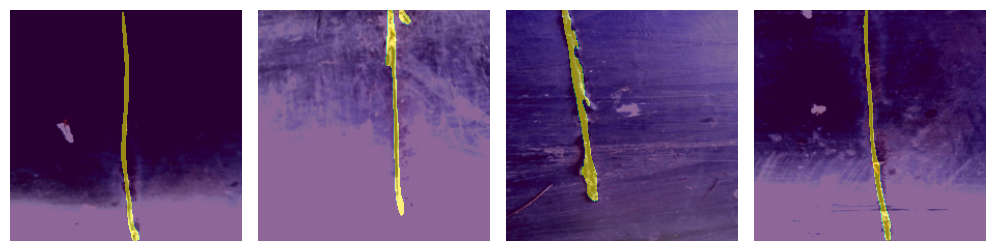

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


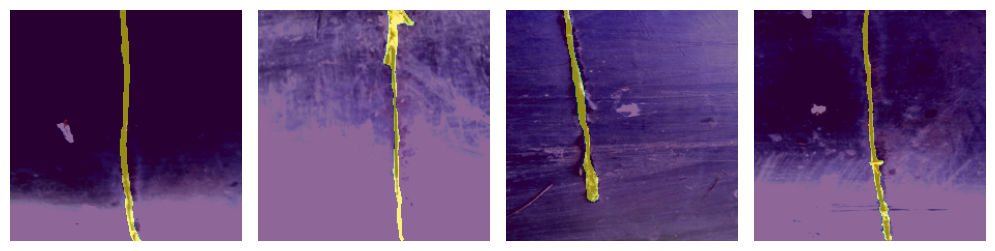

,Precision,Recall,Accuracy,Dice,IoU
0,0.990,0.719,0.992,0.833,0.714
1,0.870,0.762,0.990,0.813,0.684
2,0.766,0.929,0.991,0.840,0.724
3,0.957,0.823,0.995,0.885,0.794


In [173]:
def plot_mini_batch(imgs, masks):
    plt.figure(figsize=(20,10))
    for i in range(BATCH_SIZE):
        plt.subplot(4, 8, i+1)
        img=imgs[i,4,...].permute(1,2,0).numpy()
        mask = masks[i, ...][0].numpy()
        #print(masks==1)
        plt.imshow(img)
        plt.imshow(mask, alpha=0.6)
        
        plt.axis('Off')
    plt.tight_layout()
    plt.show()
    
imgs_val, masks_val = next(iter(val_loader))
img_cp = imgs_val.clone();masks_cp = masks_val.clone()
imgs_val = imgs_val.to(device, dtype=torch.float32)
modelo = modelo.to(device)
with torch.no_grad():
    #print(imgs_val.shape)
    imgs_valx = imgs_val.transpose(0,1)
    scores = modelo(imgs_valx)
    #print(scores.shape)
    preds = torch.argmax(scores, dim=1).float()
    
    print(preds.shape)
    print(masks_val.squeeze().shape)
    #print(preds==1)
imgs_val = imgs_val.cpu()
preds = preds.cpu()
masks_val = masks_val.cpu()

plot_mini_batch(imgs_val, preds.unsqueeze(1))
plot_mini_batch(imgs_val, masks_val)

masks_val = masks_val.numpy()
preds = preds.numpy()
metrics_table(masks_val.squeeze(), preds)

In [133]:
all_x = []
all_y = []

# Itera sobre el DataLoader para obtener los datos
for batch_x, batch_y in val_loader:
    all_x.append(batch_x)
    all_y.append(batch_y)

print(len(all_x), len(all_y))

24 24


In [134]:
modelo = modelo.to(device)
df_list = []

for imgs,masks in zip(all_x, all_y):
    imgs_val = imgs.to(device, dtype=torch.float32)
    with torch.no_grad():
        imgs_val = imgs_val.transpose(0,1)
        scores = modelo(imgs_val)
        #print(scores.shape)
        preds = torch.argmax(scores, dim=1).float()
        #print(preds.shape)
        #print(masks_val.squeeze().shape)
        #print(preds==1)
    imgs_val = imgs_val.cpu()
    preds = preds.cpu()
    preds = preds.numpy()
    masks = masks.numpy()
    df_iteration = metrics_table(masks.squeeze(), preds)
    df_list.append(df_iteration)

# Concatenate all the DataFrames together into one large DataFrame
df_combined = pd.concat(df_list, ignore_index=True)

# Calculate the median row and store it in a new DataFrame
median_row = df_combined.median(axis=0).to_frame().transpose()

print("Median Row:")
print(median_row)

Median Row:
   Precision  Recall  Accuracy    Dice     IoU
0      0.898  0.8235     0.992  0.8505  0.7395


In [ ]:
def plot_mini_batch(imgs, masks):
    plt.figure(figsize=(20,10))
    for i in range(BATCH_SIZE):
        plt.subplot(4, 8, i+1)
        img=imgs[i,4,...].permute(1,2,0).numpy()
        mask = masks[i, ...][0].numpy()
        #print(masks==1)
        plt.imshow(img)
        plt.imshow(mask, alpha=0.6)
        
        plt.axis('Off')
    plt.tight_layout()
    plt.show()

In [ ]:
import torch
# Cargar el modelo entrenado
from modelUnetConvLSTM import *

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model_read = UNET_ConvLSTM(3, 16, 2)
model_read.to(device)
model_read.load_state_dict(torch.load('UNET_LSTM_Paper_OwnDataset_TF_Dictv2.pth'))

# Establecer el modelo en modo de evaluación
model_read.eval()


imgs_val, masks_val = next(iter(val_loader))
imgs_val = imgs_val.to(device, dtype=torch.float32)
model_read = model_read.to(device)
with torch.no_grad():
    #print(imgs_val.shape)
    imgs_valx = imgs_val.transpose(0,1)
    scores = model_read(imgs_valx)
    #print(scores.shape)
    preds = torch.argmax(scores, dim=1).float()
    
    print(preds.shape)
    print(masks_val.squeeze().shape)
    #print(preds==1)
imgs_val = imgs_val.cpu()
preds = preds.cpu()

#Calculation of IOU
intersection = (preds*masks_val.squeeze()).sum()
union = (preds + masks_val.squeeze() - preds*masks_val.squeeze()).sum()
iou_value = intersection/union 
print(iou_value)
#print(preds.shape)
plot_mini_batch(imgs_val, preds.unsqueeze(1))
plot_mini_batch(imgs_val, masks_val)

In [ ]:
import segmentation_models_pytorch as smp
import torch
# Cargar el modelo entrenado
from modelUnet import UNET
model_read = UNET(3,16, 2)
model_read.load_state_dict(torch.load('UNET_Paper_10k_Images_97_Dict.pth'))

# Establecer el modelo en modo de evaluación
model_read.eval()


imgs_val, masks_val = next(iter(val_loader))
imgs_val = imgs_val.to(device, dtype=torch.float32)
model_read = model_read.to("cuda")
with torch.no_grad():
    imgs_valx = imgs_val.transpose(0,1)[4]
    scores = model_read(imgs_valx)
    print(imgs_valx.shape)
    #print(scores.shape)
    preds = torch.argmax(scores, dim=1).float()
    #print(preds==1)

imgs_val = imgs_val.cpu()
preds = preds.cpu()
masks_val = masks_val.cpu()

plot_mini_batch(imgs_val, preds.unsqueeze(1))
plot_mini_batch(imgs_val, masks_val)

masks_val = masks_val.numpy()
preds = preds.numpy()
metrics_table(masks_val.squeeze(), preds)


In [174]:
def plot_mini_batch(imgs, masks):
    plt.figure(figsize=(20,10))
    for i in range(BATCH_SIZE):
        plt.subplot(4, 8, i+1)
        img=imgs[i,...].permute(1,2,0).numpy()
        mask = masks[i, ...][0].numpy()
        #print(masks==1)
        plt.imshow(img)
        plt.imshow(mask, alpha=0.6)
        
        plt.axis('Off')
    plt.tight_layout()
    plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


UNET(
  (first_conv): Double_Conv(
    (double_conv): Sequential(
      (0): Conv_3_k(
        (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv_3_k(
        (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
    )
  )
  (down_conv1): Down_Conv(
    (encoder): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): Double_Conv(
        (double_conv): Sequential(
          (0): Conv_3_k(
            (conv1): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          )
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
          (3): Conv_3_k(
            (conv1

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


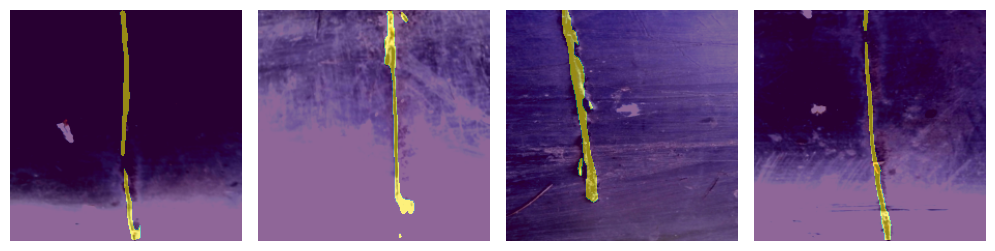

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


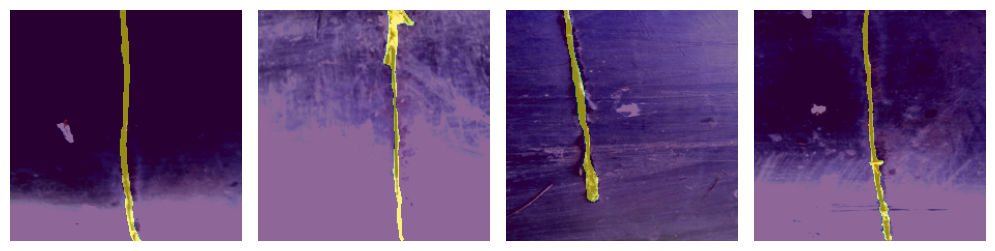

In [175]:
from modelUnet import UNET
model = UNET(3,16, 2)
model.load_state_dict(torch.load("UNET_Paper_OwnDataset_TF_Dictv3.pth"))
model.to(device)
print(model)
#imgs_valp, masks_valp = next(iter(val_loader))

imgs_val = img_cp.to(device, dtype=torch.float32)
print(imgs_val.shape)
imgs_val = imgs_val[:, 4, :, :, :]
model = model.to(device)
with torch.no_grad():
    scores = model(imgs_val)
    #print(scores.shape)
    preds = torch.argmax(scores, dim=1).float()
    #print(preds==1)
imgs_val = imgs_val.cpu()
preds = preds.cpu()
masks_val = masks_cp.cpu()

plot_mini_batch(imgs_val, preds.unsqueeze(1))
plot_mini_batch(imgs_val, masks_val)

In [ ]:
def plot_mini_batch(imgs, masks):
    plt.figure(figsize=(20,10))
    for i in range(BATCH_SIZE):
        plt.subplot(4, 8, i+1)
        img=imgs[i,...].permute(1,2,0).numpy()
        mask = masks[i, ...][0].numpy()
        #print(masks==1)
        plt.imshow(img)
        plt.imshow(mask, alpha=0.6)
        
        plt.axis('Off')
    plt.tight_layout()
    plt.show()